In [215]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

In [216]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import numpy as np

In [217]:
#load reviews
reviews=pd.read_csv("reviews_clean.csv")
reviews=reviews.dropna()

#load recipes
recipes=pd.read_csv("recipes_clean.csv")

#Convert ingredient and ingredient strings into ingredient lists
recipes["Ingredients_clean"]=recipes["Ingredients_clean"].apply(eval)
recipes["Ingredients_clean"]=recipes["Ingredients_clean"].apply(lambda x : list(set(x)))
recipes["Instructions"]=recipes["Instructions"].apply(lambda x : simple_preprocess(" ".join(eval(x))))

In [218]:
def plot_recipes(recipe_list) :
    images=[]
    labels=[]
    for recipe_ID in recipe_list :
        images.append("Images/{}.jpg".format(recipe_ID))
        labels.append(recipes[recipes["Recipe_ID"]==recipe_ID]["Recipe_name"].iloc[0]+" "+str(recipes[recipes["Recipe_ID"]==recipe_ID]["Rating"].iloc[0]))
        #labels.append(recipes.iloc[recipe_ID]["Recipe_name"])
          
    images=np.array(images)
    labels=np.array(labels)
    
    ipyplot.plot_images(images, labels=labels,max_images=100, img_width=150);
    
    return(images,labels)
    

def index_to_recipe_id(index_list) :
    id_list=[]
    for index in index_list :
        id_list.append(recipes["Recipe_ID"].iloc[index])
    return id_list

import ipyplot

def index_to_id(index_list) :
    id_list=[]
    for index in index_list :
        id_list.append(recipes["Recipe_ID"].iloc[index])
    return id_list

import ipyplot

### Content-base recipe retrieval with TFIDF (using recipe instructions)

In [219]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from gensim.models import TfidfModel
from gensim.similarities import MatrixSimilarity
from gensim.corpora import Dictionary
import numpy as np

In [220]:
#Define Dictionary of Ingredients
dictionary = Dictionary(recipes["Instructions"])

#Fiter Ingredients that appear in at least 10 recipes
dictionary.filter_extremes(no_below=100,no_above=0.5)

In [221]:
len(dictionary)

1511

In [222]:
bow_corpus = [dictionary.doc2bow(ingredients) for ingredients in recipes["Instructions"]]
model=TfidfModel(bow_corpus)
index = MatrixSimilarity(bow_corpus, num_features=len(dictionary))

In [229]:
plot_recipes(index_to_id(index[bow_corpus[100]].argsort()[-10:][::-1]));

In [230]:
plot_recipes(index_to_id(index[bow_corpus[5600]].argsort()[-10:][::-1]));

### K-Neighbors User-User Collaborative filtering recommender system

In [71]:
#Keep only recipes with more than 30 reviews
mask=reviews.groupby("Recipe_ID").size()[(reviews.groupby("Recipe_ID").size()>200)].index
reviews=reviews[reviews["Recipe_ID"].isin(mask)]
recipes=recipes[recipes["Recipe_ID"].isin(reviews["Recipe_ID"].unique())]

#Keep only users with more than 10 reviews
mask=reviews.groupby("Reviewer_ID").size()[(reviews.groupby("Reviewer_ID").size()>10)].index
reviews=reviews[reviews["Reviewer_ID"].isin(mask)]
recipes=recipes[recipes["Recipe_ID"].isin(reviews["Recipe_ID"].unique())]

In [72]:
len(reviews["Recipe_ID"].unique())

3748

In [73]:
len(reviews["Reviewer_ID"].unique())

34267

In [51]:
#Create user-item sparse pivot matrix

def create_user_item_matrix(reviews) : 
    

    from scipy.sparse import csr_matrix
    from pandas.api.types import CategoricalDtype

    user_c = CategoricalDtype(sorted(reviews["Reviewer_ID"].unique()), ordered=True)
    item_c = CategoricalDtype(sorted(reviews["Recipe_ID"].unique()), ordered=True)

    row = reviews["Reviewer_ID"].astype(user_c).cat.codes
    col = reviews["Recipe_ID"].astype(item_c).cat.codes

    user_item = csr_matrix((reviews["Rating"], (row, col)), 
                                         shape=(user_c.categories.size, item_c.categories.size))
    
    return user_item.astype("float")

In [52]:
def compute_user_similarities(user_item) : 

    # Compute user-user cosine similarity matrix 
    from sklearn.metrics.pairwise import cosine_similarity
    user_similarities = cosine_similarity(user_item,dense_output=False)    
    return user_similarities

In [25]:
def get_similar_users(user, user_similarities,k) :
    
    return (user_similarities[user].toarray().flatten()[user_similarities[user].toarray().argsort()[0][-k:-1]],
            user_similarities[user].toarray().argsort()[0][-k:-1])

In [26]:
def predict_user_ratings(user,similar_users,weights,user_item) :   
    
    user_ratings_pred= ((weights.reshape(1,weights.shape[0])*user_item[similar_users])/weights.sum()) 
     
    return  user_ratings_pred 

In [27]:
def top_n_recommendations(user,user_ratings_pred,n=10) :
    
    user_ratings_pred=np.delete(user_ratings_pred,user_item[user].nonzero()[1])
    
    return user_ratings_pred.argsort()[-n:]

In [28]:
def get_recommendations(user,user_similarities,user_item_matrix, k=20,n=10) :
    
    weights,similar_users=get_similar_users(user,user_similarities,k)
    user_ratings_pred=predict_user_ratings(user,similar_users,weights,user_item)
    
    return top_n_recommendations(user,user_ratings_pred,n)


In [74]:
user_item=create_user_item_matrix(reviews)
user_similarities=compute_user_similarities(user_item)

In [81]:
plot_recipes(recipes["Recipe_ID"].iloc[get_recommendations(58,user_similarities,user_item)].values);

In [82]:
from sklearn.model_selection import train_test_split
reviews_train,reviews_test=train_test_split(reviews,test_size=0.45,stratify=reviews[["Reviewer_ID"]])

In [83]:
len(reviews_test["Reviewer_ID"].unique())

34267

In [84]:
len(reviews_test["Recipe_ID"].unique())

3748

In [85]:
#Create train item-user and user-item matrices
user_item_train=create_user_item_matrix(reviews_train)

#Create test item-user and user-item matrices
user_item_test=create_user_item_matrix(reviews_test)

In [86]:
#scale item-user matrix 
user_mean_rating=np.array(reviews_train.groupby("Reviewer_ID")["Rating"].mean())
nz = user_item_train.nonzero()
user_item_train_scaled=user_item_train.copy()
user_item_train_scaled[user_item_train_scaled.nonzero()] -= user_mean_rating[nz[0]]

In [87]:
user_similarities_train=compute_user_similarities(user_item_train_scaled)

In [88]:
users=np.arange(len(reviews["Reviewer_ID"].unique()))
predictions=[]
for user in users :
    weights,similar_users=get_similar_users(user, user_similarities_train,5)
    user_pred=((user_item_train_scaled[similar_users].toarray().T.dot(weights))+user_mean_rating[user])
    #user_pred[user_pred>5]=5
    #user_pred[user_pred<1]=1
    predictions.append(user_pred)

In [89]:
predictions=np.array(predictions)

In [90]:
#baseline MAE evaluation
nz = user_item_test.nonzero()
np.mean((np.abs(user_item_test[nz][0]-user_mean_rating[nz[0]])))

0.5613716762832105

In [91]:
#Item item collaborative filtering MAE evaluation
np.mean(np.abs(user_item_test[nz][0]-predictions[nz]))

0.5607275536687654

In [92]:
recipes["Recipe_ID"].iloc[1192]

15810

In [93]:
sorted_predictions=predictions.argsort()

In [182]:
recommended_recipes=pd.DataFrame(sorted_predictions[:,-1:].flatten()).groupby(0).size().sort_values(ascending=False)

In [183]:
recommended_recipes

0
3747    4434
2698     330
2007     305
2617     293
3388     283
        ... 
1895       1
1896       1
3555       1
650        1
1530       1
Length: 3078, dtype: int64

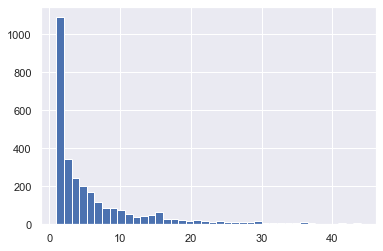

In [186]:
plt.hist(recommended_recipes[100:],bins=40);

In [204]:
plot_recipes(recipes["Recipe_ID"].iloc[sorted_predictions[:,-20:-10][1400]].values);

### Collaborative filtering with matrix factorization 

In [ ]:
from sklearn.model_selection import train_test_split
Recipe_ids_train,Recipe_ids_test=train_test_split(recipes["Recipe_ID"],test_size=0.25,random_state=42)

In [ ]:
reviews_train=reviews[reviews["Recipe_ID"].isin(Recipe_ids_train)]
reviews_test=reviews[reviews["Recipe_ID"].isin(Recipe_ids_test)]

In [709]:
from scipy.sparse.linalg import svds
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15
#Performs matrix factorization of the original user item matrix
#U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)

U, sigma, Vt = svds(user_item.asfptype(), k = NUMBER_OF_FACTORS_MF)

In [714]:
U.shape

(50092, 15)

In [ ]:
all_user_predicted_ratings = np.dot(np.dot(U,np.diag(sigma)),Vt )

In [ ]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = users_reviews_pivot_matrix.columns, index=users_reviews_pivot_matrix.index).transpose()

In [ ]:
cf_preds_df[240].sort_values(ascending=False).index[:10]

In [ ]:
cf_preds_df

In [ ]:
plot_recipes(cf_preds_df[521].sort_values(ascending=False).index[:20]);

In [ ]:
plot_recipes(cf_preds_df[22079061].sort_values(ascending=False).index[:20]);